In [ ]:

import pandas as pd
import random
import openai
import chardet
import re
import time
import tiktoken
from ast import literal_eval
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from tqdm import tqdm
from openai.error import RateLimitError, APIError
encoding = tiktoken.encoding_for_model("text-embedding-3-small")
MAX_TOKENS = 8000


In [39]:
def clean_description(text):
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    # Remove line breaks / tabs
    text = re.sub(r'[\r\n\t]', ' ', text)
    # Remove words with digits (e.g. device codes)
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)
    # Remove all remaining non-alphanumerics
    text = re.sub(r'[^a-z ]+', ' ', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [40]:
# Extract numeric priority
def clean_priority(val):
    val = str(val)
    return int(''.join(filter(str.isdigit, val))) if any(char.isdigit() for char in val) else None

In [41]:
df = pd.read_csv('clean_dataset.csv') 
df.head(10)

,number,short_description,description,priority,u_region,u_division,cmdb_ci,u_close_code
0,INC6658799,Mobile Office | My error is not listed / repor...,"This ticket was created by a store employee, s...",Prio 3,GB,LDL,ST-MDE,Resolved by Problem Ticket
1,INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,Here we have exactly the same incident as INC...,Prio 3,ES,LDL,ST-MDE,Solved - Error did not appear again
2,INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,"The mobile device 21342B62DB on store 1696, wa...",Prio 3,FR,LDL,ST-MDE,Works as designed
3,INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,Mobile device (21349B1921) locked in landscape...,Prio 3,FR,LDL,ST-MDE,Works as designed
4,INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,Since the Android 10 update on the 21172B39DD ...,Prio 3,FR,LDL,ST-MDE,Works as designed
5,INC7255265,2659 - MUZILLAC - DR07 - INP MOBI # S/N : 2117...,--------------- LIDL ---------------\r\n> Expé...,Prio 2,FR,LDL,ST-MDE,Works as designed
6,INC7300612,0530 - CLERMONT-FERRAND - DR12 - MoBi - perdu ...,--------------- LIDL ---------------\r\n> Expé...,Prio 3,FR,LDL,ST-MDE,Works as designed
7,INC7337800,1090 - Lidl-Store: PARIS - DR10 - Mobi - aucun...,------------ LIDL ---------------\r\n> Expédit...,Prio 3,FR,LDL,ST-MDE,Works as designed
8,INC7345428,3930 - Lidl-Store: BAGNOLET - DR10 - Mobi - Pr...,------------ LIDL ---------------\r\n> Expédit...,Prio 3,FR,LDL,ST-MDE,Works as designed
9,INC7350179,1155 - ST GERMAIN VILLAGE Lisieux - DR11 -...,--------------- LIDL ---------------\r\n> Expé...,Prio 3,FR,LDL,ST-MDE,Works as designed


In [42]:
# calling the first funtion to clean variable
df['clean_desc'] = df['description'].apply(clean_description)

In [43]:
# calling the second funtion to clean variable
df['priority_num'] = df['priority'].apply(clean_priority)

In [44]:
df.head(5)

,number,short_description,description,priority,u_region,u_division,cmdb_ci,u_close_code,clean_desc,priority_num
0,INC6658799,Mobile Office | My error is not listed / repor...,"This ticket was created by a store employee, s...",Prio 3,GB,LDL,ST-MDE,Resolved by Problem Ticket,this ticket was created by a store employee st...,3
1,INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,Here we have exactly the same incident as INC...,Prio 3,ES,LDL,ST-MDE,Solved - Error did not appear again,here we have exactly the same incident as it i...,3
2,INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,"The mobile device 21342B62DB on store 1696, wa...",Prio 3,FR,LDL,ST-MDE,Works as designed,the mobile device on store warehouse is locked...,3
3,INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,Mobile device (21349B1921) locked in landscape...,Prio 3,FR,LDL,ST-MDE,Works as designed,mobile device locked in landscape mode since t...,3
4,INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,Since the Android 10 update on the 21172B39DD ...,Prio 3,FR,LDL,ST-MDE,Works as designed,since the android update on the honeywell devi...,3


In [45]:
df_des = df["clean_desc"]
df_des

0        this ticket was created by a store employee st...
1        here we have exactly the same incident as it i...
2        the mobile device on store warehouse is locked...
3        mobile device locked in landscape mode since t...
4        since the android update on the honeywell devi...
                               ...                        
49370    store reported that hydra on scanner not worki...
49371    contacto cargo tel de contacto isidro as incid...
49372    contacto cargo tel de contacto eduardo adjunto...
49373    this ticket was created by a store employee st...
49374    cieszyn tel ma gorzata kromczyk sn posiadamy d...
Name: clean_desc, Length: 49375, dtype: object

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49375 entries, 0 to 49374
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   number             49375 non-null  object
 1   short_description  49375 non-null  object
 2   description        49374 non-null  object
 3   priority           49375 non-null  object
 4   u_region           49232 non-null  object
 5   u_division         49375 non-null  object
 6   cmdb_ci            49375 non-null  object
 7   u_close_code       49375 non-null  object
 8   clean_desc         49375 non-null  object
 9   priority_num       49375 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 3.8+ MB


In [47]:
df.shape

(49375, 10)

In [48]:
df_null_sum = df.isnull().sum()
df_null_sum

number                 0
short_description      0
description            1
priority               0
u_region             143
u_division             0
cmdb_ci                0
u_close_code           0
clean_desc             0
priority_num           0
dtype: int64

In [ ]:
# # Function to obtain the embedding for lots one by one
# def get_embedding(text, model="text-embedding-3-small"):
#     # Clean the text (remove newlines)
#     text = text.replace("\n", " ")
#     # Call the embeddings API directly from the openai module
#     response = openai.Embedding.create(
#         input=[text],
#         model=model
#     )
#     # Return the embedding from the response
#     return response["data"][0]["embedding"]

# # Convert the 'review' column to string type
# df['embedding'] = df['review'].astype(str)
# # ⚙️ Generar embeddings para cada texto
# tqdm.pandas()  

# # Generate embeddings for each review text
# df['embedding'] = df['embedding'].progress_apply(lambda x: get_embedding(x))
# embeddings = df['embedding'].tolist()



In [49]:
df.dropna(inplace=True)  # Drop rows with NaN in 'dataframe'

In [50]:
# Drop original 'description' and 'priority'
df_clean = df.drop(columns=['description', 'priority'])

In [51]:
df_null_sum = df_clean.isnull().sum()
df_null_sum

number               0
short_description    0
u_region             0
u_division           0
cmdb_ci              0
u_close_code         0
clean_desc           0
priority_num         0
dtype: int64

In [52]:
df_clean

,number,short_description,u_region,u_division,cmdb_ci,u_close_code,clean_desc,priority_num
0,INC6658799,Mobile Office | My error is not listed / repor...,GB,LDL,ST-MDE,Resolved by Problem Ticket,this ticket was created by a store employee st...,3
1,INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,here we have exactly the same incident as it i...,3
2,INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,FR,LDL,ST-MDE,Works as designed,the mobile device on store warehouse is locked...,3
3,INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,FR,LDL,ST-MDE,Works as designed,mobile device locked in landscape mode since t...,3
4,INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,FR,LDL,ST-MDE,Works as designed,since the android update on the honeywell devi...,3
...,...,...,...,...,...,...,...,...
49370,INC10694407,SK4320 - problem with hydra,SK,KFL,ST-MDE,Software / Application Issue,store reported that hydra on scanner not worki...,2
49371,INC10694222,Mobile Office – PDA Terminal 01 - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,contacto cargo tel de contacto isidro as incid...,3
49372,INC10694489,Mobile Office – PDA Terminal - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,contacto cargo tel de contacto eduardo adjunto...,3
49373,INC10694601,Mobile Office | Mijn probleem is niet opgelijs...,BE,LDL,ST-MDE,Software / Application Issue,this ticket was created by a store employee st...,3


In [53]:
# 1) Drop any rows where clean_desc is empty or null
df_clean = df_clean.copy()
mask = df_clean['clean_desc'].astype(str).str.strip() != ""
df_clean = df_clean.loc[mask].reset_index(drop=True)

In [54]:
def count_tokens(texts):
    return sum(len(encoding.encode(t)) for t in texts)

In [ ]:
def embed_batch(texts, model="text-embedding-3-small", retries=2):
    # filter empty
    texts = [t if t is not None else "" for t in texts]
    # if too many tokens, split
    if count_tokens(texts) > MAX_TOKENS and len(texts) > 1:
        mid = len(texts) // 2
        return embed_batch(texts[:mid], model) + embed_batch(texts[mid:], model)
    # try embedding
    for attempt in range(retries + 1):
        try:
            resp = openai.Embedding.create(model=model, input=texts)
            return [d["embedding"] for d in resp["data"]]
        except (RateLimitError, APIError, TimeoutError) as e:
            if attempt < retries and len(texts) > 1:
                mid = len(texts) // 2
                return embed_batch(texts[:mid], model, retries) + embed_batch(texts[mid:], model, retries)
            wait = 2 ** attempt
            print(f"[Attempt {attempt+1}] Error: {e}. Retrying split in {wait}s...")
            time.sleep(wait)
    # if all retries fail, raise
    raise RuntimeError(f"Batch embedding failed for {len(texts)} texts")

# Prepare texts
texts = df_clean['clean_desc'].tolist()
batch_size = 64

# Containers
all_embeddings = []
failed_batches = []  # store (start_index, batch_texts, error)

# Loop with logging
for start in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
    batch = texts[start: start + batch_size]
    try:
        embs = embed_batch(batch)
        all_embeddings.extend(embs)
    except Exception as e:
        print(f"Batch starting at {start} failed: {e}")
        failed_batches.append((start, batch, str(e)))
        # Inspect: save this batch to a file so you can inspect manually
        with open(f"failed_batch_{start}.txt", "w", encoding="utf-8") as f:
            f.write("\n".join(batch))
        # Fallback: attempt one-by-one to avoid loss
        for idx, text in enumerate(batch):
            try:
                emb = embed_batch([text])[0]
                all_embeddings.append(emb)
            except Exception as e2:
                print(f"  Single text at index {start + idx} also failed: {e2}")
                # placeholder zero-vector (match embedding dim)
                dim = len(all_embeddings[0]) if all_embeddings else 1536
                all_embeddings.append([0.0] * dim)

# Verify lengths
assert len(all_embeddings) == len(texts), \
    f"Embeddings count {len(all_embeddings)} != texts {len(texts)}"

# Attach back
df_clean['embedding'] = all_embeddings

# After running, inspect failed_batches list for problematic texts:
print("Failed batches:", failed_batches)
df_clean.to_parquet("processed.parquet", index=False)

Embedding batches: 100%|██████████| 763/763 [19:03<00:00,  1.50s/it]

Failed batches: []


In [57]:
df_clean.to_parquet("processed.parquet", index=False)


In [71]:
df_1 = pd.read_parquet("processed.parquet")

In [70]:
# True si en alguna fila sigue habiendo un string en vez de lista o array
has_strings = df_1['embedding'].apply(lambda x: isinstance(x, str)).any()
print("¿Hay embeddings como strings?", has_strings)


¿Hay embeddings como strings? False


In [74]:
lengths = df_1['embedding'].apply(len)
print("Unique embedding dimensions:", lengths.unique())

Unique embedding dimensions: [1536]


In [75]:
import numpy as np
# This turns the list‑of‑floats in each row into a proper 2D array
X = np.vstack(df_1['embedding'].values) 

In [72]:
df_1.head(5)

,number,short_description,u_region,u_division,cmdb_ci,u_close_code,clean_desc,priority_num,embedding
0,INC6658799,Mobile Office | My error is not listed / repor...,GB,LDL,ST-MDE,Resolved by Problem Ticket,this ticket was created by a store employee st...,3,"[-0.04034459963440895, 0.02698301523923874, 0...."
1,INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,here we have exactly the same incident as it i...,3,"[-0.008323092944920063, 0.019566569477319717, ..."
2,INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,FR,LDL,ST-MDE,Works as designed,the mobile device on store warehouse is locked...,3,"[-0.007481252308934927, 0.036391958594322205, ..."
3,INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,FR,LDL,ST-MDE,Works as designed,mobile device locked in landscape mode since t...,3,"[0.0008254850981757045, 0.025297028943896294, ..."
4,INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,FR,LDL,ST-MDE,Works as designed,since the android update on the honeywell devi...,3,"[-0.04337901622056961, 0.016848208382725716, 0..."


In [73]:
df_1.shape

(48790, 9)

Clustering The data with the 2 Variables

In [76]:
import matplotlib.pyplot as plt

# The elbow method to check and determine in how many clusters we should cluster the data
def optimise_kmeans(data, max_k):
    means = []	
    inertia = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertia.append(kmeans.inertia_)
    
    
    fig = plt.figure(figsize=(10, 6))
    plt.plot(means, inertia, marker='o', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show

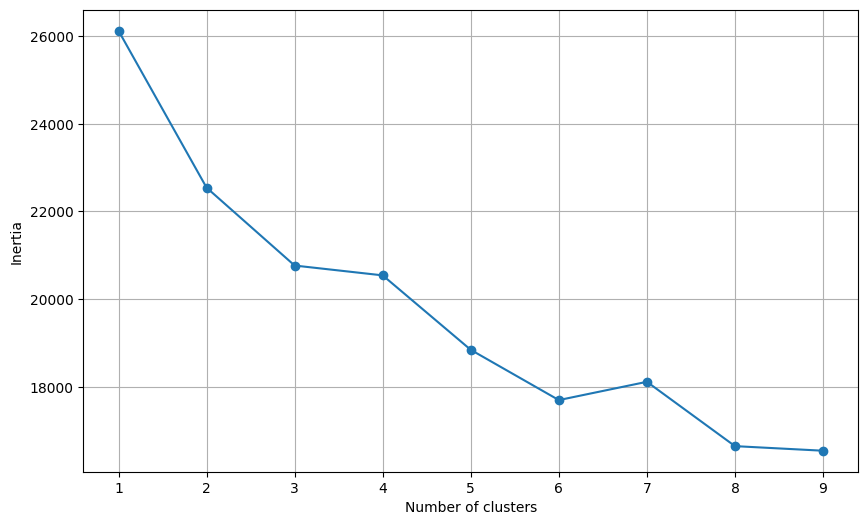

In [77]:
optimise_kmeans(X, max_k=10)


In [78]:
from sklearn.cluster import KMeans

n_clusters = 6  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)  # X is the data matrix with embeddings + priority

df_1['cluster'] = labels


Plotting Results

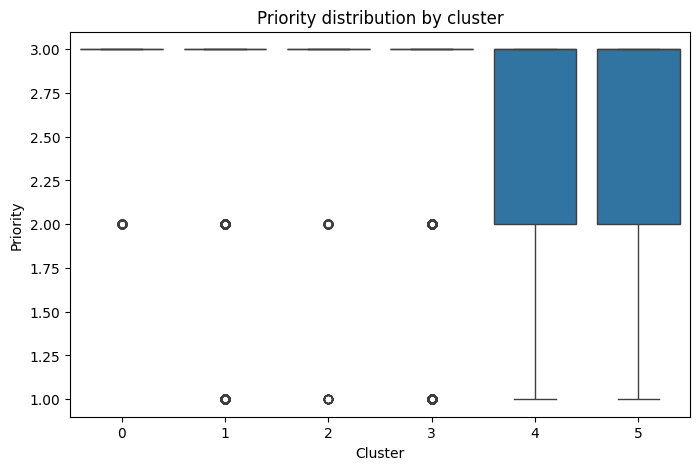

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='cluster', y='priority_num', data=df_1)
plt.title('Priority distribution by cluster')
plt.xlabel('Cluster')
plt.ylabel('Priority')
plt.show()



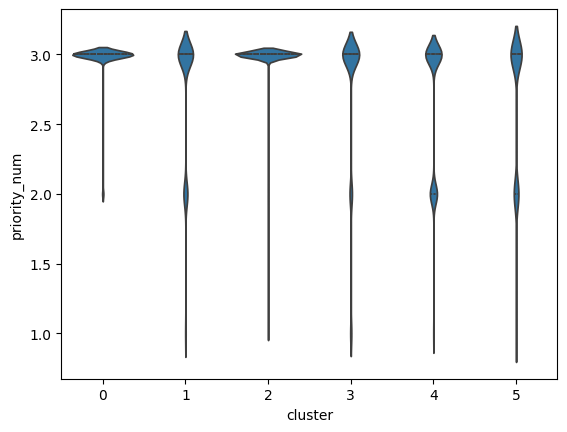

In [81]:
sns.violinplot(x='cluster', y='priority_num', data=df_1, inner='quartile')
plt.show()

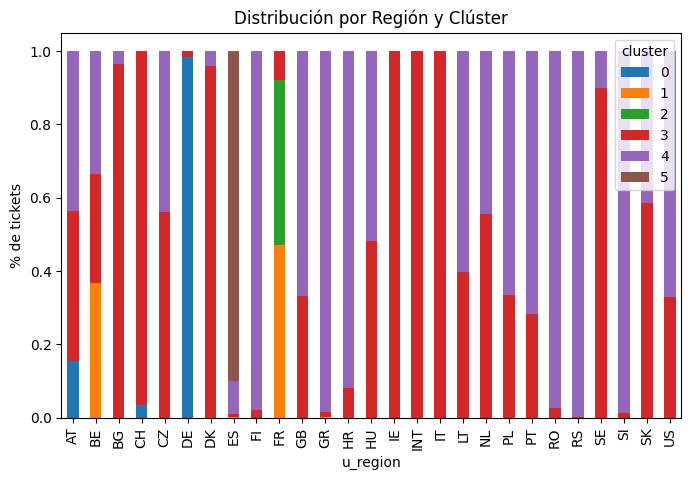

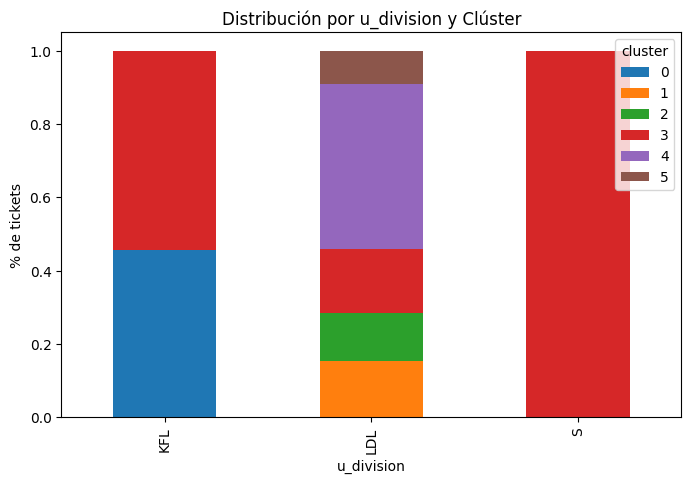

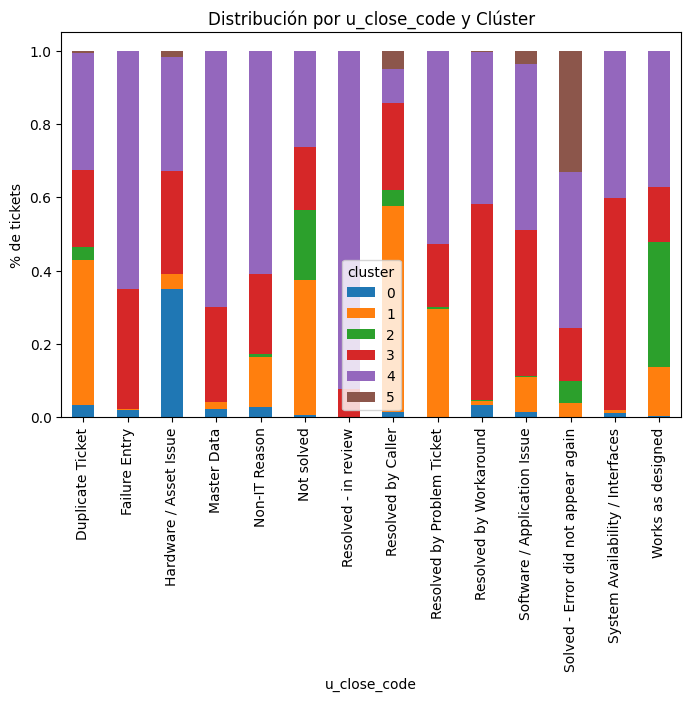

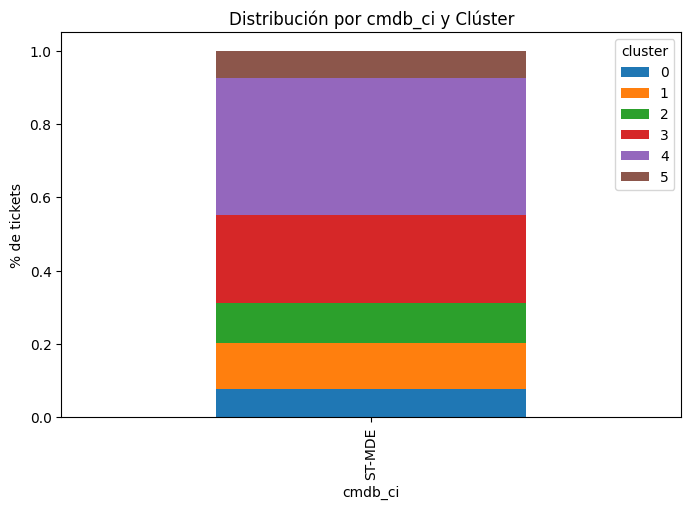

In [82]:
# Conteo de tickets por región y clúster
pd.crosstab(df_1['u_region'], df_1['cluster'], normalize='index') \
  .plot(kind='bar', stacked=True, figsize=(8,5), title='Distribución por Región y Clúster')
plt.ylabel('% de tickets')
plt.show()

# Lo mismo para división, close_code o cmdb_ci
for col in ['u_division','u_close_code','cmdb_ci']:
    pd.crosstab(df_1[col], df_1['cluster'], normalize='index') \
      .plot(kind='bar', stacked=True, figsize=(8,5), title=f'Distribución por {col} y Clúster')
    plt.ylabel('% de tickets')
    plt.show()


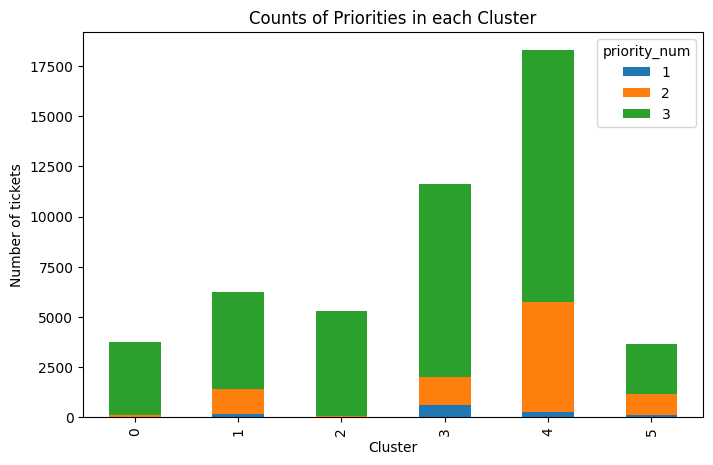

In [83]:
pd.crosstab(df_1['cluster'], df_1['priority_num']) \
  .plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Counts of Priorities in each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of tickets')
plt.show()


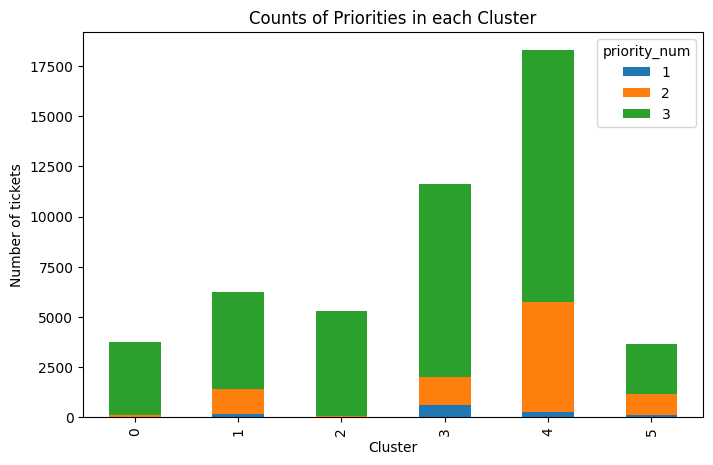

In [84]:
pd.crosstab(df_1['cluster'], df_1['priority_num']) \
  .plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Counts of Priorities in each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of tickets')
plt.show()


In [85]:
# unique incident count per cluster
inc_count = df_1.groupby('cluster')['number'].nunique()
print(inc_count)

cluster
0     3723
1     6211
2     5299
3    11628
4    18302
5     3627
Name: number, dtype: int64


In [86]:
# 👀 6. Inspect each cluster manually
for i in range(n_clusters):
    print(f"\n🔹 Cluster {i}:")
    print(df_1[df_1['cluster'] == i]['clean_desc'].head(5).to_string(index=False))



🔹 Cluster 0:
sn mac ip fehlerbeschreibung l dt nicht mehr ak...
sn mac ip fehlerbeschreibung l dt nicht mehr kk...
sn mac ip fehlerbeschreibung l dt nicht mehr ak...
fehlerbeschreibung mde hat einen riss im displa...
sn mac ip fehlerbeschreibung display flackert d...

🔹 Cluster 1:
en description lidl exp dition type simple prio...
this ticket was created by a store employee sto...
this ticket was created by a store employee sto...
this ticket was created by a store employee sto...
this ticket was created by a store employee sto...

🔹 Cluster 2:
lidl exp dition priorit j type avec change gest...
lidl exp dition type simple priorit j gestion c...
lidl exp dition priorit j type avec change gest...
lidl exp dition priorit j type avec change gest...
lidl exp dition priorit j type avec change gest...

🔹 Cluster 3:
here we have exactly the same incident as it is...
the mobile device on store warehouse is locked ...
mobile device locked in landscape mode since th...
since the android update o

In [ ]:
def categorize_and_explain_cluster(descriptions):
    
    sample_size = min(20, len(descriptions))

    # Randomly select 'sample_size' reviews from the cluster
    random_sample = random.sample(descriptions, sample_size)
    text_sample = "\n".join(random_sample)
    # Create a prompt for the model
    prompt = (
        "These are product descriptions from one cluster:\n\n" +
        text_sample +
        "\n\nBased on these reviews, assign a general category (a short label) for this group, "
        "and explain in detail the key factors or recurring themes that led you to choose this category."
    )
    
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini-2024-07-18",  # Latest model as requested
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
    )
    
    return response["choices"][0]["message"]["content"]


In [ ]:
# Dictionary to hold each cluster's summary and explanation
cluster_summaries = {}

for cluster_label in sorted(df_1['cluster'].unique()):
    # Get all reviews for this cluster as a list
    descriptions = df_1[df_1['cluster'] == cluster_label]['clean_desc'].tolist()
    summary = categorize_and_explain_cluster(descriptions)
    cluster_summaries[cluster_label] = summary
    print(f"\nCluster {cluster_label} Summary and Explanation:\n")
    print(summary)

In [89]:
cluster_names = {
    0: "Device Malfunctions and Repair Requests",
    1: "Technical Support Issues with Mobile Devices",
    2: "Technology Equipment Support and Management",
    3: "Hardware Malfunctions and Technical Issues",
    4: "Technical Support Issues in Retail Operations",
    5: "Technical Device Issues and Support Requests",
}

# new column with descriptive cluster names
df_1['cluster_name'] = df_1['cluster'].map(cluster_names)



# Save the updated DataFrame with descriptive names to CSV
df_1.to_csv("With_clusters_nameOPENAI.csv", index=False)

In [90]:
df = pd.read_csv('With_clusters_nameOPENAI.csv')
df.head(10) 

,number,short_description,u_region,u_division,cmdb_ci,u_close_code,clean_desc,priority_num,embedding,cluster,cluster_name
0,INC6658799,Mobile Office | My error is not listed / repor...,GB,LDL,ST-MDE,Resolved by Problem Ticket,this ticket was created by a store employee st...,3,[-0.0403446 0.02698302 0.03903169 ... -0.00...,4,Technical Support Issues in Retail Operations
1,INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,here we have exactly the same incident as it i...,3,[-0.00832309 0.01956657 0.02247426 ... -0.01...,3,Hardware Malfunctions and Technical Issues
2,INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,FR,LDL,ST-MDE,Works as designed,the mobile device on store warehouse is locked...,3,[-0.00748125 0.03639196 -0.00684808 ... 0.02...,3,Hardware Malfunctions and Technical Issues
3,INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,FR,LDL,ST-MDE,Works as designed,mobile device locked in landscape mode since t...,3,[ 0.00082549 0.02529703 0.03505411 ... 0.02...,3,Hardware Malfunctions and Technical Issues
4,INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,FR,LDL,ST-MDE,Works as designed,since the android update on the honeywell devi...,3,[-0.04337902 0.01684821 0.01982284 ... -0.00...,3,Hardware Malfunctions and Technical Issues
5,INC7255265,2659 - MUZILLAC - DR07 - INP MOBI # S/N : 2117...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,2,[-0.00512237 0.03671644 0.011913 ... -0.01...,2,Technology Equipment Support and Management
6,INC7300612,0530 - CLERMONT-FERRAND - DR12 - MoBi - perdu ...,FR,LDL,ST-MDE,Works as designed,lidl exp dition type simple priorit j gestion ...,3,[-0.01646094 0.02828854 0.01656456 ... -0.01...,2,Technology Equipment Support and Management
7,INC7337800,1090 - Lidl-Store: PARIS - DR10 - Mobi - aucun...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,3,[-0.0084793 0.04281595 0.01367773 ... -0.01...,2,Technology Equipment Support and Management
8,INC7345428,3930 - Lidl-Store: BAGNOLET - DR10 - Mobi - Pr...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,3,[ 0.0257046 0.04382202 0.010591 ... -0.01...,2,Technology Equipment Support and Management
9,INC7350179,1155 - ST GERMAIN VILLAGE Lisieux - DR11 -...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,3,[-0.00625989 0.02914764 0.02187954 ... -0.01...,2,Technology Equipment Support and Management


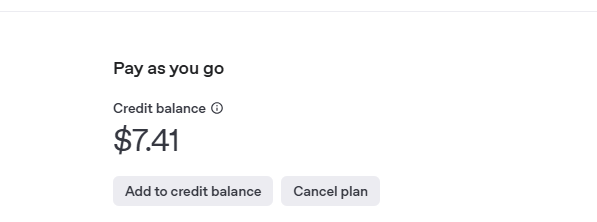